# This notebook can be used to analyze results of super-resolution on WSI patches using PCGAN from 128 to 256

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, ToPILImage
from torchvision.utils import save_image, make_grid
import os
from copy import deepcopy
import numpy as np
from torch import Tensor
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import ImageDraw, ImageFont, Image
from typing import Tuple

In [3]:
from super_image_resolution.utils import load_torch_module, dump, make_dirs, load, split, find_files
from super_image_resolution.datasets import CustomDataset
from super_image_resolution.modules.unet import UNet
from super_image_resolution.metrics import compute_ssim, compute_psnr
from super_image_resolution.plotting import display_random_output
from super_image_resolution.plotting import plot_grid

# Splitting Whole Slide Images (WSIs) into train, validation and test set

In [4]:
hparams = load(
    "/home/mittal.nit/projects/super_image_resolution/assets/"
    f"pcgan_wsi_patches_128to256/version_4/hparams/hparams.p")
metrics = load(hparams["metrics_path"])


Successfully loaded /home/mittal.nit/projects/super_image_resolution/assets/pcgan_wsi_patches_128to256/version_4/hparams/hparams.p

Successfully loaded /home/mittal.nit/projects/super_image_resolution/assets/pcgan_wsi_patches_128to256/version_4/metrics/metrics.p


In [5]:
hparams

{'in_channels': 3,
 'out_channels': 3,
 'gen_norm': 'batchnorm',
 'gen_act': 'lrelu',
 'gen_final_act': 'tanh',
 'dis_norm': 'batchnorm',
 'dis_act': 'lrelu',
 'dis_final_act': 'relu',
 'dis_depth': 3,
 'dis_kernel_size': 4,
 'dis_stride': 2,
 'dis_padding': 1,
 'gen_loss_weight': 100.0,
 'dis_loss_weight': 1.0,
 'dis_lr': 0.0001,
 'gen_lr': 0.0001,
 'gen_step_interval': 1,
 'dis_step_interval': 3,
 'val_step_interval': 200,
 'val_output_save_interval': 10,
 'max_val_batches': -1,
 'max_num_val_output_save': 2,
 'device': device(type='cuda'),
 'experiment_version': 4,
 'experiment_save_path': '/home/mittal.nit/projects/super_image_resolution/assets/pcgan_wsi_patches_128to256/version_4',
 'modules_dir': '/home/mittal.nit/projects/super_image_resolution/assets/pcgan_wsi_patches_128to256/version_4/modules',
 'metrics_dir': '/home/mittal.nit/projects/super_image_resolution/assets/pcgan_wsi_patches_128to256/version_4/metrics',
 'metrics_save_interval': 50,
 'verbose': False,
 'kwargs': {'se

In [6]:
SEED = hparams["kwargs"]["seed"]
SPLIT_RATIO = hparams["kwargs"]["split_ratio"]
FROM_SIZE = hparams["kwargs"]["from_size"]
TO_SIZE = hparams["kwargs"]["to_size"]
TEST_BATCH_SIZE = 64
train_wsi, val_wsi, test_wsi = split(
    path="/scratch/mittal.nit/Post-NAT-BRCA/samples256x256_v2/", 
    ratios=SPLIT_RATIO, 
    seed=SEED)
TEST_IMAGES_PATH = os.path.join(
    os.path.dirname(os.path.dirname(hparams["hparams_path"])),
    "test")
make_dirs(TEST_IMAGES_PATH)

print(f"Number of WSI in train: {len(train_wsi)}, val: {len(val_wsi)}, test: {len(test_wsi)}")
train_patches = [patch for wsi in train_wsi for patch in find_files(wsi, ext="png")]
val_patches = [patch for wsi in val_wsi for patch in find_files(wsi, ext="png")]
test_patches = [patch for wsi in test_wsi for patch in find_files(wsi, ext="png")]
print(f"Number of patches in train: {len(train_patches)}, val: {len(val_patches)}, test: {len(test_patches)}")


/home/mittal.nit/projects/super_image_resolution/assets/pcgan_wsi_patches_128to256/version_4/test already exists
Number of WSI in train: 55, val: 10, test: 4
Number of patches in train: 11000, val: 2000, test: 800


## Defining input and output transformations

In [7]:
in_transforms = Compose([
    Resize(size=FROM_SIZE, interpolation=InterpolationMode.BICUBIC),
    Resize(size=TO_SIZE, interpolation=InterpolationMode.BICUBIC), 
    ToTensor()
])

out_transforms = Compose([
    ToTensor()
])

## Defining PyTorch based dataset and dataloader

In [8]:
test_dataset = CustomDataset(
    paths=test_patches,
    in_transforms=in_transforms,
    out_transforms=out_transforms)

test_loader = DataLoader(
    test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False)

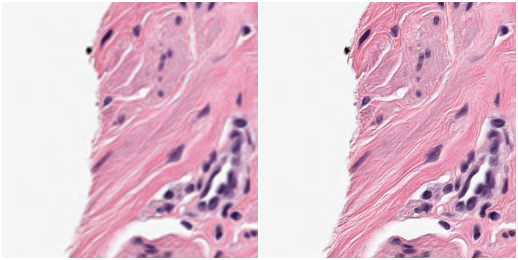

In [9]:
fps, X, Y = next(iter(test_loader))
ToPILImage()(make_grid(tensor=[X[0], Y[0]], pad_value=1.),)

In [10]:
unet = UNet(
    in_channels=hparams["in_channels"],
    out_channels=hparams["out_channels"], 
    norm=hparams["gen_norm"], 
    activation=hparams["gen_act"], 
    final_act=hparams["gen_final_act"])
unet.load_state_dict(torch.load(hparams["gen_path"]))
unet.to(hparams["device"])

UNet(
  (encoder): UNetEncoder(
    (downs): ModuleList(
      (0): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

In [11]:
def testing_step(model, X: Tensor) -> Tensor:
    """Test step for super-resolution pix-2-pix model."""
    torch.set_grad_enabled(False)
    model.eval()
    return model(X)

In [12]:
ssim_in, ssim_out = [], []
psnr_in, psnr_out = [], []

FPs, Xs, Ys, Y_hats = [], [], [], []
for fps, X, Y in tqdm(test_loader, leave=False, position=True):
    Y_hat = testing_step(unet, X.to(hparams["device"]))
    X, Y_hat = X.to("cpu"), Y_hat.to("cpu")
    Y_hat = torch.clamp(Y_hat, 0., 1.)
    
    i, o  = compute_ssim(X, Y, Y_hat)    
    ssim_in += i
    ssim_out += o

    i, o = compute_psnr(X, Y, Y_hat)
    psnr_in += i
    psnr_out += o
    
    FPs += [fp for fp in fps]
    Xs += [x for x in X]
    Ys += [y for y in Y]
    Y_hats += [y_hat for y_hat in Y_hat]


                                               
                                               [A
                                               [A
                                               [A
                                                A
                                               [A
                                                A
                                               [A
                                               [A
                                               [A
                                               
                                               
                                               
100%|██████████| 13/13 [00:53<00:00,  3.68s/it]
                                               

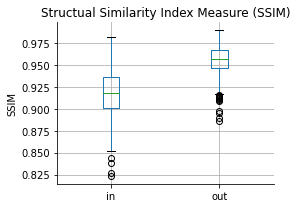

In [74]:
test_metrics = pd.DataFrame(data={
    "ssim_in": ssim_in,
    "ssim_out": ssim_out,
    "psnr_in": psnr_in, 
    "psnr_out": psnr_out})

fig, ax = plt.subplots(figsize=(4, 3))
test_metrics.boxplot(column=["ssim_in", "ssim_out"], ax=ax)
ax.set_title("Structual Similarity Index Measure (SSIM)")
ax.set_xticklabels(["in", "out"])
ax.set_ylabel("SSIM")
sns.despine(ax=ax)
plt.tight_layout()
plt.savefig(os.path.join(TEST_IMAGES_PATH, "test_ssim.png"), dpi=300)
plt.show()

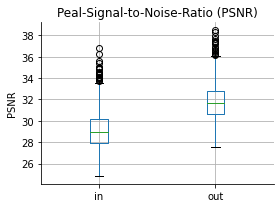

In [75]:
fig, ax = plt.subplots(figsize=(4, 3))
test_metrics.boxplot(column=["psnr_in", "psnr_out"], ax=ax)
ax.set_title("Peal-Signal-to-Noise-Ratio (PSNR)")
ax.set_xticklabels(["in", "out"])
ax.set_ylabel("PSNR")
sns.despine(ax=ax)
plt.tight_layout()
plt.savefig(os.path.join(TEST_IMAGES_PATH, "test_psnr.png"), dpi=300)
plt.show()

In [15]:
n = 20
idxs = np.argsort(np.array(ssim_out) - np.array(ssim_in))[-n:]

def extract_slide_patch_id(fp: str) -> Tuple[str, str]:
    """Extract slide and patch id from patch filename."""
    patch_id = os.path.basename(fp)
    fp = os.path.dirname(fp)
    slide_id = os.path.basename(fp)
    return slide_id, patch_id

for i in tqdm(idxs, leave=False, position=0):
    slide_id, patch_id = extract_slide_patch_id(FPs[i])
    img = plot_grid(
#         Compose(
#             [
#                 Resize(128, InterpolationMode.BICUBIC),
#                 Resize(256, InterpolationMode.BICUBIC),
#                 ToTensor()
#             ])(ToPILImage()(Xs[i])),
        Xs[i],
        Ys[i], 
        Y_hats[i], 
        padding=20)
    img.save(os.path.join(TEST_IMAGES_PATH, f"{slide_id}_{patch_id}"))

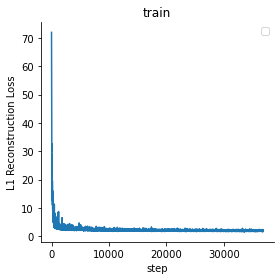

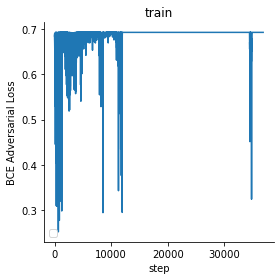

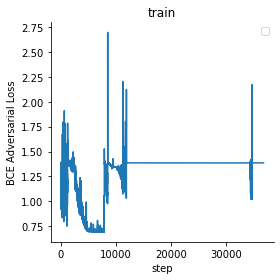

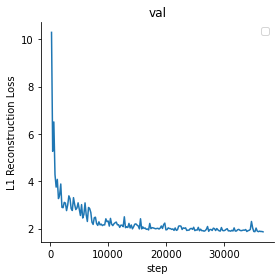

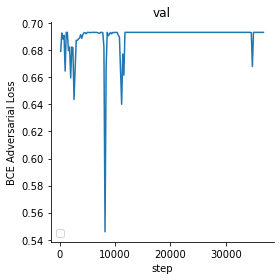

In [76]:
for mode in metrics.keys():
    if mode in ["train", "val"]:
        for loss_type, losses in metrics[mode].items():
            losses = pd.DataFrame(
                losses, columns=["step", f"{mode}_{loss_type}"]).set_index("step")
            if len(losses) > 0:
                losses = losses.groupby("step").mean()
                fig, ax = plt.subplots(figsize=(4,4))
                losses.plot(ax=ax)
                ax.legend("")
                ax.set_title(mode)
                ax.set_ylabel(
                    "L1 Reconstruction Loss" if "reconst" in loss_type else "BCE Adversarial Loss")
                sns.despine(ax=ax)
                plt.tight_layout()
                plt.savefig(
                    os.path.join(
                        TEST_IMAGES_PATH, 
                        f"{mode}_{loss_type}.png"), dpi=300)

In [64]:
losses

,val_dis_adv_loss
step,


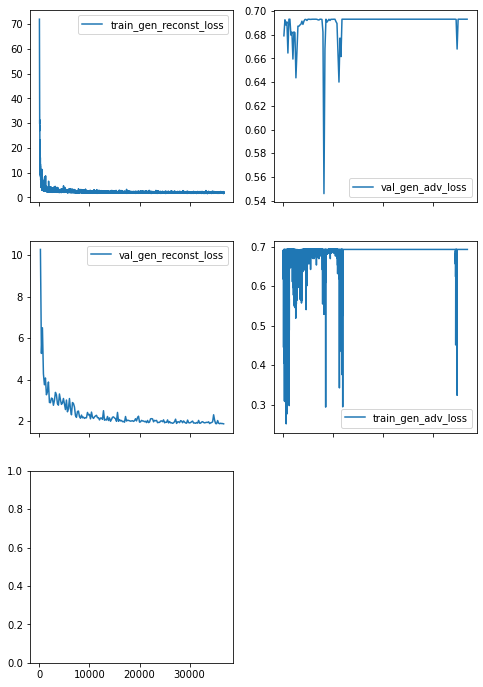

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12), sharex=True)

train_gen_reconst_loss = pd.DataFrame(
    metrics["train"]["gen_reconst_loss"], 
    columns=["step", "train_gen_reconst_loss"]).set_index("step")
train_gen_reconst_loss = train_gen_reconst_loss.groupby("step").mean()
train_gen_reconst_loss.plot(ax=axes[0,0])

val_gen_reconst_loss = pd.DataFrame(
    metrics["val"]["gen_reconst_loss"], 
    columns=["step", "val_gen_reconst_loss"]).set_index("step")
val_gen_reconst_loss = val_gen_reconst_loss.groupby("step").mean()
val_gen_reconst_loss.plot(ax=axes[1,0])

train_gen_adv_loss = pd.DataFrame(
    metrics["train"]["gen_adv_loss"], 
    columns=["step", "train_gen_adv_loss"]).set_index("step")
train_gen_adv_loss = train_gen_adv_loss.groupby("step").mean()
train_gen_adv_loss.plot(ax=axes[1,1])

val_gen_adv_loss = pd.DataFrame(
    metrics["val"]["gen_adv_loss"], 
    columns=["step", "val_gen_adv_loss"]).set_index("step")
val_gen_adv_loss = val_gen_adv_loss.groupby("step").mean()
val_gen_adv_loss.plot(ax=axes[0,1])

fig.delaxes(axes[2][1])

In [55]:
36850/hparams["dis_step_interval"]

12283.333333333334

In [52]:
len(metrics["train"]["gen_adv_loss"]), len(metrics["train"]["dis_adv_loss"])

(36850, 12283)

In [17]:
ToPILImage()(
    make_grid(
        Ys[:8], 
        padding=10,
        pad_value=1.,
        nrow=4)).save(
    os.path.join(TEST_IMAGES_PATH, "test_samples.png"))

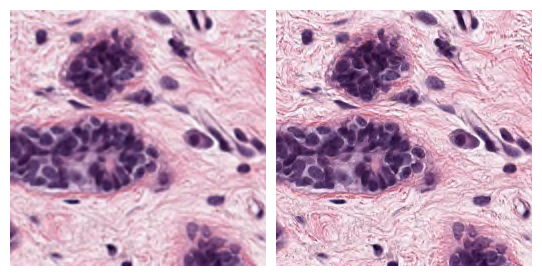

In [47]:
def convert2low(img):
    img = Compose(
            [
                Resize(128, InterpolationMode.BICUBIC),
                Resize(256, InterpolationMode.BICUBIC),
                ToTensor()
            ])(ToPILImage()(img))
    return img


# Train patches
train_dataset = CustomDataset(
    paths=train_patches,
    in_transforms=in_transforms,
    out_transforms=out_transforms)

train_loader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=False)

i = 11
fps, X, Y = next(iter(train_loader))
img = ToPILImage()(
    make_grid(
        torch.cat([X[i:i+1], Y[i:i+1]]), 
        padding=10,
        pad_value=1.,
        nrow=4))
img

In [48]:
img.save(os.path.join(TEST_IMAGES_PATH, "train_sample.png"))

In [33]:
convert2low(X[5]).shape

torch.Size([3, 256, 256])